# Chart of weeks taken and model accuracy

In this notebook we will take a look on how the number of weeks taken as an input to the model changes the model accuracy. We will also produce multiple models with varying preprocessing to compare its effectiveness.

In [1]:
%matplotlib inline

import sys
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as plt
import helpers_models as hm
import transforms
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sb.set_style('white')
plt.rcParams['figure.figsize'] = (14,10)

So first, load the data. Then add target and split it to train and test.

In [2]:
data = hm.load_pivot_numbers()

In [3]:
first_week, last_week = data['tweets'].columns.min(), data['tweets'].columns.max()

In [4]:
data = hm.make_target(data, last_week)

In [5]:
train, test = train_test_split(data)

Now balance the train dataset.

In [6]:
train = hm.balance_data(train)

We have the input data. It's time to make the pipelines for the models.

In [7]:
pipe_base = Pipeline([
    ('weeks', transforms.WeeksLimiter(first_week, last_week)),
    ('logreg', LogisticRegressionCV())
])

In [8]:
pipe_norm = Pipeline([
    ('weeks', transforms.WeeksLimiter(first_week, last_week)),
    ('norm', transforms.Normalizer()),
    ('logreg', LogisticRegressionCV())
])

In [9]:
pipe_decay = Pipeline([
    ('weeks', transforms.WeeksLimiter(first_week, last_week)),
    ('decay', transforms.TimeDecayApplier(last_week)),
    ('logreg', LogisticRegressionCV())
])

In [10]:
pipe_norm_decay = Pipeline([
    ('weeks', transforms.WeeksLimiter(first_week, last_week)),
    ('norm', transforms.Normalizer()),
    ('decay', transforms.TimeDecayApplier(last_week)),
    ('logreg', LogisticRegressionCV())
])

Now let's iterate over the weeks, train the models, and note their performaces into a data frame.

In [11]:
scores = pd.DataFrame()

In [12]:
%%time
for starting_week in range(first_week, last_week):
    print()
    print('TRAINING STARTING WEEK', starting_week)
    
    # update pipes
    for pipe in [pipe_base, pipe_norm, pipe_decay, pipe_norm_decay]:
        pipe.set_params(weeks__first_week=starting_week)
        
    row = {
        'weeks taken': last_week - starting_week
    }
        
    # train and score pipes
    for pipe, name in [
        (pipe_base, 'base'),
        (pipe_norm, 'normalized'),
        (pipe_decay, 'with time decay'),
        (pipe_norm_decay, 'normalized with time decay')
    ]:
        print('fitting', name)
        pipe.fit(train.drop('target', axis=1, level=0), train['target'])
        
        print('scoring', name)
        predicted = pipe.predict(test.drop('target', axis=1, level=0))
        score = accuracy_score(test['target'], predicted)
        
        # save to row
        row[name] = score
        
    # add the row with scores
    scores = scores.append(row, ignore_index=True)


TRAINING STARTING WEEK 23
fitting base
scoring base
fitting normalized
scoring normalized
fitting with time decay
scoring with time decay
fitting normalized with time decay
scoring normalized with time decay

TRAINING STARTING WEEK 24
fitting base
scoring base
fitting normalized
scoring normalized
fitting with time decay
scoring with time decay
fitting normalized with time decay
scoring normalized with time decay

TRAINING STARTING WEEK 25
fitting base
scoring base
fitting normalized
scoring normalized
fitting with time decay
scoring with time decay
fitting normalized with time decay
scoring normalized with time decay

TRAINING STARTING WEEK 26
fitting base
scoring base
fitting normalized
scoring normalized
fitting with time decay
scoring with time decay
fitting normalized with time decay
scoring normalized with time decay

TRAINING STARTING WEEK 27
fitting base
scoring base
fitting normalized
scoring normalized
fitting with time decay
scoring with time decay
fitting normalized with t

Finally, print the chart.

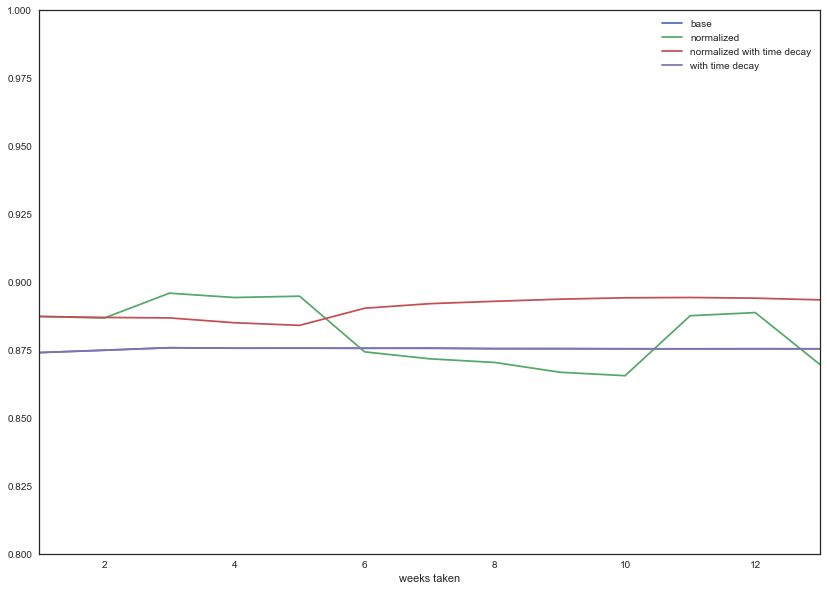

In [13]:
scores.set_index('weeks taken').sort_index().plot(ylim=(0.8, 1))